In [112]:
%reload_ext autoreload
%autoreload 2
import os
import shapley_value
import pandas as pd
import numpy as np
from getting_data import read_conf
from xai_process import get_smp_shap_data
from s2search_score_pdp import pdp_based_importance

ds_list = [
    'cslg', 'cscv', 'csai', 'csit', 'cscl',
    'cscr', 'csds', 'cssy', 'csni', 'csro',
    'csdc', 'cssi', 'cslo', 'csna', 'cscy',
    'csdm', 'csir', 'csne', 'csse', 'cscc',
    'cshc', 'csgt', 'cssd', 'csdb', 'cscg',
    'cspl', 'csma', 'csce', 'csfl', 'csdl',
    'csmm', 'csgr', 'cspf', 'csar', 'cset', 
    'csoh', 'cssc', 'csms',
]

In [113]:
xai_metrics_arr = []

def aggregation(arr):
    return np.std(arr, ddof=1)
    # return np.mean(np.abs(arr))
    # return pdp_based_importance(arr)

for sample_name in ds_list:
    exp_name = f'exp-{sample_name}'
    exp_path = os.path.join('.', f'pipelining/{exp_name}')
    sv = shapley_value.compute_shapley_value(exp_name, sample_name)
    
    data_len = sv.shape[0]

    sv_fi = [
        aggregation(sv[col])
        for col in sv.columns
    ]
    
    ale_fi = []
    for feature_name in ['title', 'abstract', 'venue', 'authors', 'year', 'n_citations']:
        ale_npz_file = os.path.join(exp_path, 'scores', f'{sample_name}_1w_ale_{feature_name}.npz')
        ale_fi.append(aggregation(np.load(ale_npz_file)['ale_result']))
    

    anchor_fi = []
    _, sample_configs, __  = read_conf(exp_path)
    metrics = dict(
        title=[],
        abstract=[],
        venue=[],
        authors=[],
        year=[],
        n_citations=[],
    )
    for sample_key in sample_configs.keys():
        sample_tasks = sample_configs[sample_key]['anchor']['task']
        for task in sample_tasks:
            rg = task['range']
            m_file = os.path.join(exp_path, 'scores', f"{sample_key}_anchor_metrics_{rg[0]}_{rg[1]}.npz")
            if os.path.exists(m_file):
                ld = np.load(m_file)
                title = ld['title']
                abstract = ld['abstract']
                venue = ld['venue']
                authors = ld['authors']
                year = ld['year']
                n_citations = ld['n_citations']
                idx = ld['idx']
                
                metrics['title'].extend(title)
                metrics['abstract'].extend(abstract)
                metrics['venue'].extend(venue)
                metrics['authors'].extend(authors)
                metrics['year'].extend(year)
                metrics['n_citations'].extend(n_citations)
                
    for feature_name in ['title', 'abstract', 'venue', 'authors', 'year', 'n_citations']:
        if len(metrics[feature_name]) < data_len:
            zeros = np.zeros([data_len - len(metrics[feature_name])])
            metrics[feature_name].extend(list(zeros))
        anchor_fi.append(aggregation(metrics[feature_name]))
    
    shap_fi = []
    shap_sv = get_smp_shap_data(exp_name)[sample_name]['shap_sv']
                
    shap_sv = np.flipud(np.rot90(np.array(shap_sv)))
    for feature_sv in shap_sv:
        shap_fi.append(aggregation(feature_sv))
                
    xai_metrics_arr.append([
        sample_name,
        ale_fi, 
        sv_fi,
        anchor_fi,
        shap_fi
    ])
    
fis = ['ALE Feature Importance', 'Shapley Value Feature Importance', 'Anchors Feature Importance', 'SHAP Feature Importance']

xai_fi_metrics_pd = pd.DataFrame(columns=['dataset', *fis], data=xai_metrics_arr)

# xai_fi_metrics_pd

[3.5407320790973884, 5.783221489974318, 3.490913476682037, 0.0, 0.6203497171620237, 0.3478295361072694]
[3.975431706591543, 7.18094759940575, 2.302897270123843, 0.015405339465744697, 0.7567136348863532, 0.2322766425481537]
[0.1621890642194246, 0.270705157563376, 0.08914838401661265, 0.022724903331537406, 0.1310718806847891, 0.07223952895438152]
[2.6545495628205535, 5.676325596747008, 1.4403790684120734, 0.0, 0.6254890303641569, 0.23256962337355713]


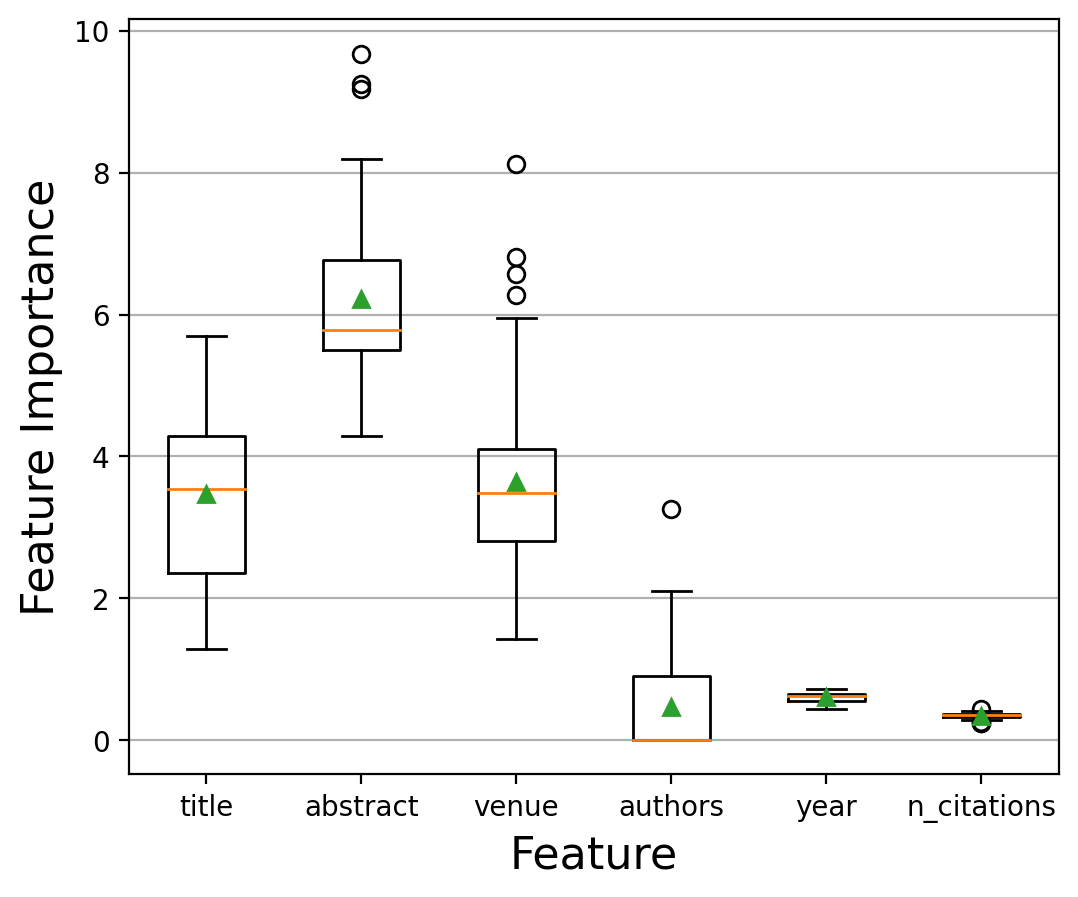

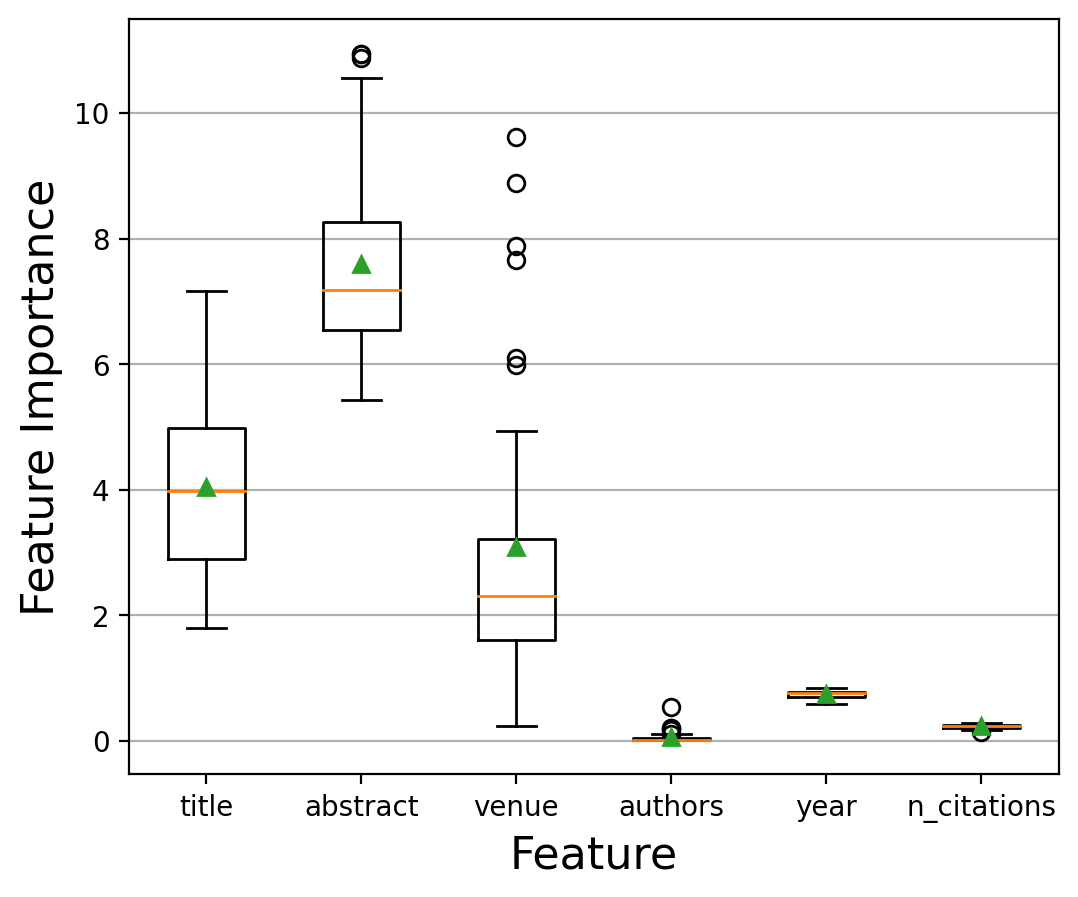

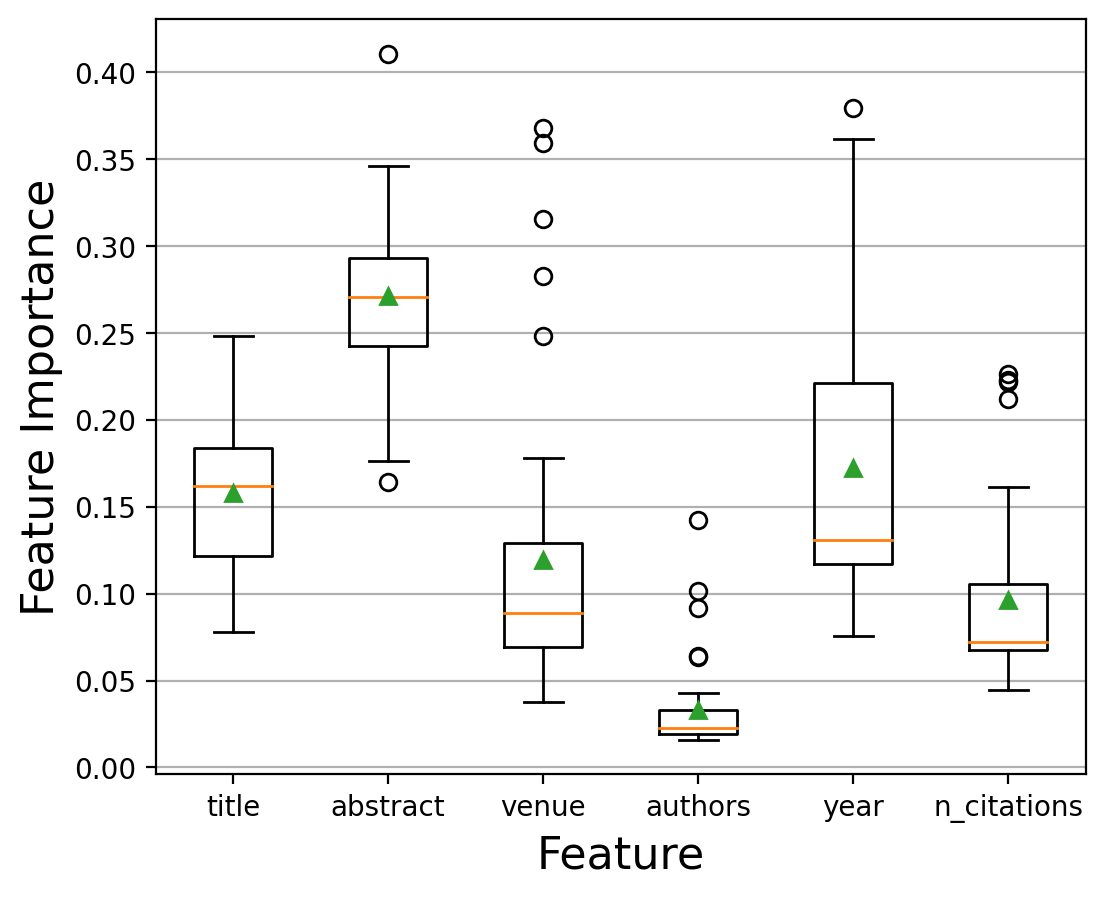

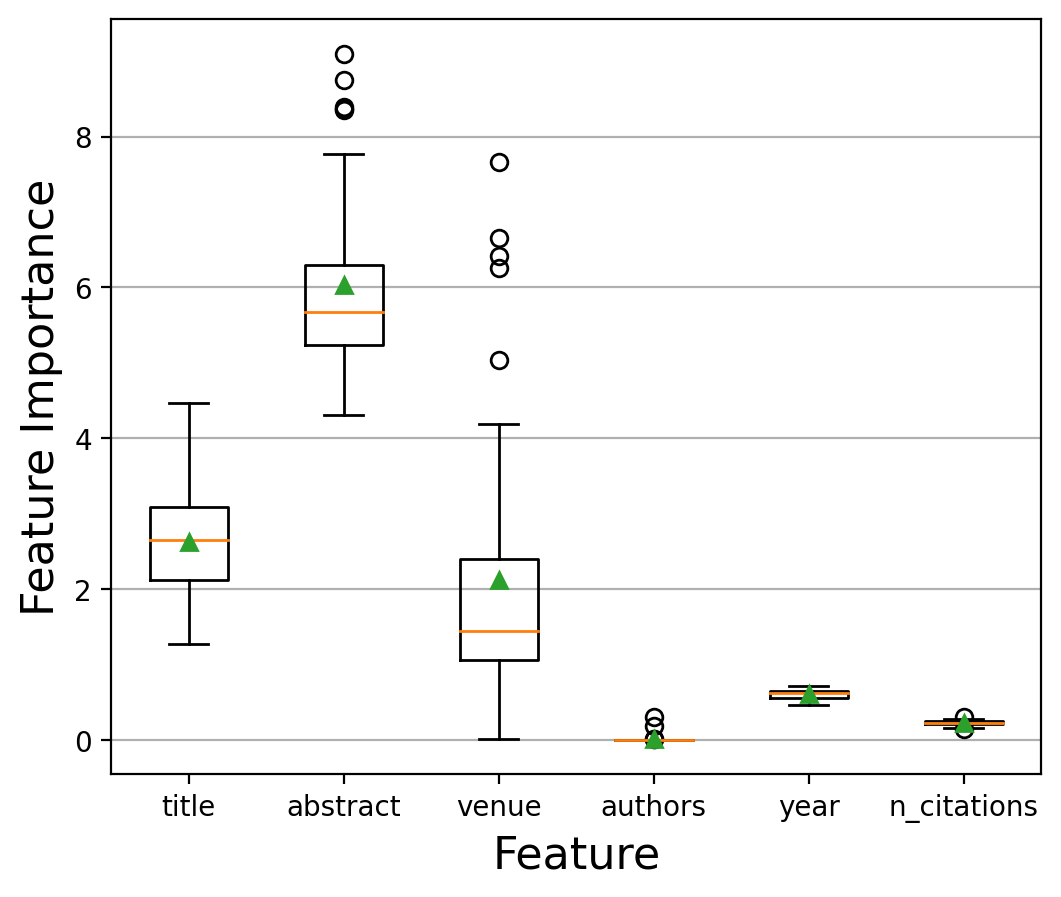

In [119]:
import matplotlib.pyplot as plt

for fi in fis:
    fi_data = (xai_fi_metrics_pd[fi].to_list())
    fi_data = np.transpose(fi_data)
    all_data = [list(l) for l in fi_data]
    md_arr = [np.median(l) for l in all_data]
    print(md_arr)
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 5), dpi=200)

    # plot box plot
    ax.boxplot(all_data, 
                # showfliers=False, 
                showmeans=True,
                )
    # ax.set_title(f'Box Plot of {fi}')

    ax.yaxis.grid(True)
    ax.set_xticks([y + 1 for y in range(len(all_data))],
                    labels=['title', 'abstract', 'venue', 'authors', 'year', 'n_citations'], fontsize=10)
    ax.set_xlabel('Feature', fontsize=16)
    ax.set_ylabel(f'Feature Importance', fontsize=16)


In [115]:
from datetime import datetime
from xai_process import get_smp_shap_paper_count_from_log, get_smp_shap_time_from_log
pd.set_option('display.expand_frame_repr', False)

log_metrics_arr = []

for sample_name in ds_list:
    exp_name = f'exp-{sample_name}'
    exp_path = os.path.join('.', f'pipelining/{exp_name}')
    
    log_path = os.path.join(exp_path, 'log')
    
    log_files_name = os.listdir(log_path)
    
    # get anchor time
    anchor_log_files = [lf for lf in log_files_name if f'{sample_name}_anchor' in lf]
    
    anchor_time_sec = 0.0
    for anchor_log_file in anchor_log_files:
        with open(os.path.join(log_path, anchor_log_file))as f:
            lines = [l.strip() for l in f.readlines() if l.strip() != '']
            anchor_time_sec += float(lines[-1].strip().split('witin ')[1])
    
    # get anchor paper count
    anchor_calls_log_files = [lf for lf in log_files_name if 'ranker_calls_anchor' in lf]

    anchor_paper_count = 0
    for anchor_calls_file in anchor_calls_log_files:
        with open(os.path.join(log_path, anchor_calls_file))as f:
            lines = [l.strip() for l in f.readlines() if l.strip() != '']
            for i in range(len(lines)):
                if i > 0:
                    pre_line = lines[i - 1].strip()
                    curr_line = lines[i].strip()
                    if f'{exp_name} {sample_name}' in pre_line and '=== end' in curr_line:
                        anchor_paper_count += int(curr_line.replace('=', '').replace('end', '').replace(' ', ''))
    
    
    # get shap time
    shap_time_sec = get_smp_shap_time_from_log(exp_name, [sample_name])[sample_name]
    # get shap paper count
    shap_paper_count = get_smp_shap_paper_count_from_log(exp_name, [sample_name])[sample_name]

    
    # get masking paper count and time
    masking_calls_log_files = [lf for lf in log_files_name if 'ranker_calls_masking' in lf]
    
    masking_paper_count = 0
    masking_time_sec = 0
    for masking_calls_file in masking_calls_log_files[-1:]:
        with open(os.path.join(log_path, masking_calls_file))as f:
            lines = [l.strip() for l in f.readlines() if l.strip() != '']
            start_line = None
            end_line = None
            for i in range(len(lines)):
                curr_line = lines[i].strip()
                if i > 0:
                    pre_line = lines[i - 1].strip()
                    if f'{exp_name}_{sample_name}' in pre_line and '=== end' in curr_line:
                        masking_paper_count += int(curr_line.replace('=', '').replace('end', '').replace(' ', ''))
                if f'{exp_name}_{sample_name}' in curr_line:
                    if start_line == None:
                        start_line = curr_line
                    end_line = curr_line
            
            # print(log_path, masking_calls_file)
            start_time = datetime.strptime(start_line[1:start_line.index(']')], '%m/%d/%Y, %H:%M:%S')
            end_time = datetime.strptime(end_line[1:end_line.index(']')], '%m/%d/%Y, %H:%M:%S')
            
            masking_time_sec = (end_time - start_time).total_seconds()
            
    # get ale paper count and time
    ale_calls_log_files = [lf for lf in log_files_name if 'ranker_calls_ale' in lf]
    
    ale_paper_count = 0
    ale_time_sec = 0
    for ale_calls_file in ale_calls_log_files:
        with open(os.path.join(log_path, ale_calls_file))as f:
            lines = [l.strip() for l in f.readlines() if l.strip() != '']
            start_line = None
            end_line = None
            for i in range(len(lines)):
                curr_line = lines[i].strip()
                if i > 0:
                    pre_line = lines[i - 1].strip()
                    if f'{exp_name}_{sample_name}' in pre_line and '=== end' in curr_line:
                        ale_paper_count += int(curr_line.replace('=', '').replace('end', '').replace(' ', ''))
                if f'{exp_name}_{sample_name}' in curr_line:
                    if start_line == None:
                        start_line = curr_line
                    end_line = curr_line
            
            start_time = datetime.strptime(start_line[1:start_line.index(']')], '%m/%d/%Y, %H:%M:%S')
            end_time = datetime.strptime(end_line[1:end_line.index(']')], '%m/%d/%Y, %H:%M:%S')
            
            ale_time_sec = (end_time - start_time).total_seconds()
    
    log_metrics_arr.append([
        sample_name,
        ale_paper_count, ale_time_sec,
        masking_paper_count, masking_time_sec,
        shap_paper_count, round(shap_time_sec, 0),
        anchor_paper_count, round(anchor_time_sec, 0),
    ])
    # break

ms = ['ale paper', 'ale time', 'masking paper', 'masking time', 'shap paper', 'shap time','anchor paper', 'anchor time',]

log_metrics_pd = pd.DataFrame(columns=['dataset', *ms], data=log_metrics_arr)

print(log_metrics_pd)
# print(log_metrics_pd[['dataset', *[s for s in ms if 'paper' in s]]])

   dataset  ale paper  ale time  masking paper  masking time  shap paper  shap time  anchor paper  anchor time
0     cslg    1487008     972.0        5948032        2849.0    77787366   236387.0     134091249     132012.0
1     cscv    1032496     712.0        4129984        2052.0    53972638   130763.0     119488218     119303.0
2     csai     629504     406.0        2518016        1146.0    32878648    54597.0      62694316      53953.0
3     csit     574976     423.0        2299904        1139.0    29867136    51452.0      70142017      65025.0
4     cscl     492000     310.0        1968000         772.0    25506880    39101.0      47660783      42776.0
5     cscr     309984     191.0        1239936         456.0    16067794    18663.0      35199241      29013.0
6     csds     304272     193.0        1217088         429.0    15774008    18337.0      35123110      30047.0
7     cssy     284992     189.0        1139968         607.0    14767496    19174.0      38348909      37647.0
8

In [116]:
from xai_process import get_smp_shap_time_from_log
get_smp_shap_time_from_log('exp-inhouse')

{'cslg': 236387.48929899998,
 'cscv': 130763.24924500001,
 'csai': 54793.774435,
 'csit': 51452.47601699999,
 'cscl': 37892.727568,
 'cscr': 19984.42053,
 'csds': 18843.671666,
 'cssy': 19173.870015999997,
 'csni': 15396.538973999997,
 'csro': 14665.266641999999,
 'csdc': 13022.130112,
 'cssi': 14577.982808999997,
 'cslo': 8876.767346,
 'csna': 9503.029594,
 'cscy': 8461.312933000001,
 'csdm': 7816.470743000001,
 'csir': 8756.865684,
 'csne': 8522.915251999999,
 'csse': 8839.318549,
 'cscc': 7150.578614999999,
 'cshc': 7306.313557,
 'csgt': 6592.210872999999,
 'cssd': 4964.734757000001,
 'csdb': 4036.267797,
 'cspl': 3797.1071709999997,
 'cscg': 3572.320696,
 'csce': 3255.137623,
 'csma': 3276.490917,
 'csmm': 2146.82674,
 'csdl': 2461.473261,
 'csgr': 2057.0846109999998,
 'csfl': 2632.9903699999995,
 'cspf': 1652.9079980000001,
 'csar': 1770.768388,
 'cset': 1584.3185059999998,
 'csoh': 885.6887820000001,
 'csms': 990.759211,
 'cssc': 958.773431,
 'csos': 373.786345,
 'csgl': 78.74233

In [117]:
param_arr = []

for sample_name in ds_list:
    exp_name = f'exp-{sample_name}'
    exp_path = os.path.join('.', f'pipelining/{exp_name}')

    _, sample_configs, __  = read_conf(exp_path)
    
    ale_quantiles = sample_configs[sample_name]['ale_1w'][0]['quantiles']
    
    param_arr.append([
        sample_name,
        [ale_quantiles[feature] for feature in ['title', 'abstract', 'venue', 'authors', 'year', 'n_citations']]
    ])

l1 = ['ale quantiles']

param_df = pd.DataFrame(columns=['dataset', *l1], data=param_arr)

param_df

,dataset,ale quantiles
0,cslg,"[2, 2, 2, 2, 2, 2]"
1,cscv,"[2, 2, 2, 2, 2, 2]"
2,csai,"[2, 2, 2, 2, 2, 2]"
3,csit,"[2, 2, 2, 2, 2, 2]"
4,cscl,"[5, 5, 5, 5, 5, 5]"
5,cscr,"[5, 5, 5, 5, 5, 5]"
6,csds,"[5, 5, 5, 5, 5, 5]"
7,cssy,"[5, 5, 5, 5, 5, 5]"
8,csni,"[5, 5, 5, 5, 5, 5]"
9,csro,"[5, 5, 5, 5, 5, 5]"
